In [2]:
import random
from pathlib import Path
import tarfile
from typing import Any
from logging import INFO
from collections import defaultdict, OrderedDict
from collections.abc import Sequence, Callable
import numbers

import numpy as np
import torch
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from enum import IntEnum
import flwr
from flwr.server import History, ServerConfig
from flwr.server.strategy import FedAvgM as FedAvg, Strategy
from flwr.common import log, NDArrays, Scalar, Parameters, ndarrays_to_parameters
from flwr.client.client import Client

from common.client_utils import (
    Net,
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    train_femnist,
    test_femnist,
    save_history,
)


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


PathType = Path | str | None


def get_device() -> str:
    """Get the device (cuda, mps, cpu)."""
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

In [3]:
home_dir = Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

# Decompress dataset
if not dataset_dir.exists():
    with tarfile.open(home_dir / "femnist.tar.gz", "r:gz") as tar:
        tar.extractall(path=home_dir)
    log(INFO, "Dataset extracted in %s", dataset_dir)

In [4]:
def set_model_parameters(net: Module, parameters: NDArrays) -> Module:
    """Put a set of parameters into the model object."""
    weights = parameters
    params_dict = zip(net.state_dict().keys(), weights, strict=False)
    state_dict = OrderedDict({k: torch.from_numpy(np.copy(v)) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)
    return net


def get_model_parameters(net: Module) -> NDArrays:
    """Get the current model parameters as NDArrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [5]:
class FlowerRayClient(flwr.client.NumPyClient):
    """Flower client for the FEMNIST dataset."""

    def __init__(
        self,
        cid: int,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        """Init the client with its unique id and the folder to load data from.

        Parameters:
            cid (int): Unique client id for a client used to map it to its data
                partition
            partition_dir (Path): The directory containing data for each
                client/client id
            model_generator (Callable[[], Module]): The model generator function
        
        """
        self.cid = cid
        log(INFO, "cid: %s", self.cid)
        self.partition_dir = partition_dir
        self.device = str(
            torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        )
        self.model_generator: Callable[[], Module] = model_generator
        self.properties: dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}

    def set_parameters(self, parameters: NDArrays) -> Module:
        """Load weights inside the network."""
        net = self.model_generator()
        return set_model_parameters(net, parameters)

    def get_parameters(self, config: dict[str, Scalar]) -> NDArrays:
        """Return weights from a given model.

        If no model is passed, then a local model is created.
        This can be used to initialise a model in the
        server.
        The config param is not used but is mandatory in Flower.

        """
        net = self.model_generator()
        return get_model_parameters(net)

    def fit(self, parameters: NDArrays, config: dict[str, Scalar]) -> tuple[NDArrays, int, dict]:
        """Receive and train a model on the local client data."""
        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)

        train_loader: DataLoader = self._create_data_loader(config, name="train")
        train_loss = self._train(net, train_loader=train_loader, config=config)
        return get_model_parameters(net), len(train_loader), {"train_loss": train_loss}

    def evaluate(self, parameters: NDArrays, config: dict[str, Scalar]) -> tuple[float, int, dict]:
        """Receive and test a model on the local client data."""
        net = self.set_parameters(parameters)
        net.to(self.device)

        test_loader: DataLoader = self._create_data_loader(config, name="test")
        loss, accuracy = self._test(net, test_loader=test_loader, config=config)
        return loss, len(test_loader), {"local_accuracy": accuracy}

    def _create_data_loader(self, config: dict[str, Scalar], name: str) -> DataLoader:
        """Create the data loader using the specified config parameters."""
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name)
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name: str) -> Dataset:
        full_file: Path = self.partition_dir / str(self.cid)
        return load_femnist_dataset(
            mapping=full_file,
            name=name,
            data_dir=data_dir,
        )

    def _train(
        self, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
    ) -> float:
        return train_femnist(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def _test(
        self, net: Module, test_loader: DataLoader, config: dict[str, Scalar]
    ) -> tuple[float, float]:
        return test_femnist(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def get_properties(self, config: dict[str, Scalar]) -> dict[str, Scalar]:
        """Return properties for this client."""
        return self.properties

    def get_train_set_size(self) -> int:
        """Return the client train set size."""
        return len(self._load_dataset("train"))  # type: ignore[reportArgumentType]

    def get_test_set_size(self) -> int:
        """Return the client test set size."""
        return len(self._load_dataset("test"))  # type: ignore[reportArgumentType]


def fit_client_seeded(
    client: FlowerRayClient,
    params: NDArrays,
    conf: dict[str, Any],
    seed: Seeds = Seeds.DEFAULT,
    **kwargs: Any,
) -> tuple[NDArrays, int, dict]:
    """Wrap to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)

In [6]:
def get_flower_client_generator(
    model_generator: Callable[[], Module],
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrap the client instance generator.

    A mapping function could be used for filtering/ordering clients.

    Parameters
    ----------
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Create a single client instance given the client id `cid`."""
        return FlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

## Centralized Baseline (1 FL client only)

In [7]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(network_generator, centralized_partition)
)
centralized_flower_client = centralized_flower_client_generator(str(0))

INFO flwr 2025-02-22 11:47:23,876 | 4203729913.py:21 | cid: 0


In [12]:
centralized_train_config: dict[str, Any] = {
    "epochs": 4,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client, params=seed_model_params, conf=centralized_train_config
)
log(INFO, "Train Metrics = %s", train_metrics)

INFO flwr 2025-02-22 11:48:58,226 | 2944962118.py:20 | Train Metrics = {'train_loss': 0.07441831767559051}


In [13]:
# Test trained parameters on the centralised dataset
loss, num_examples, test_metrics = centralized_flower_client.evaluate(
    parameters=trained_params, config=test_config
)
log(INFO, "Loss = %s; Test Metrics = %s", loss, test_metrics)

  4%|▍         | 100/2329 [00:02<00:55, 39.87it/s]
INFO flwr 2025-02-22 11:49:01,374 | 592755603.py:5 | Loss = 217.45845246315002; Test Metrics = {'local_accuracy': 0.3975}


## Federated setting with natural partitions

In [16]:
def sample_random_clients(
    total_clients: int,
    filter_less: int,
    partition: Path,
    seed: int | None = Seeds.DEFAULT,
) -> Sequence[int]:
    """Sample randomly clients.

    A filter on the client train set size is performed.

    Parameters
    ----------
        total_clients (int): total number of clients to sample.
        filter_less (int): max number of train samples for which the client is
            **discarded**.
        partition (Path): path to the folder containing the partitioning.
    """
    real_federated_cid_client_generator: Callable[[str], FlowerRayClient] = (
        get_flower_client_generator(network_generator, federated_partition)
    )
    if seed is not None:
        random.seed(seed)
    list_of_ids = []
    while len(list_of_ids) < total_clients:
        current_id = random.randint(0, 3229)
        if (
            real_federated_cid_client_generator(str(current_id)).get_train_set_size()
            > filter_less
        ):
            list_of_ids.append(current_id)
    return list_of_ids

While FEMNIST has more than 3000 clients, we will limit our experiments to 100 (for now).

In [18]:
total_clients: int = 100
list_of_ids = sample_random_clients(
    total_clients, centralized_train_config["batch_size"], federated_partition
)

federated_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(
        network_generator, federated_partition, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-02-22 11:52:09,027 | 4203729913.py:21 | cid: 2530
INFO flwr 2025-02-22 11:52:09,033 | 4203729913.py:21 | cid: 2184
INFO flwr 2025-02-22 11:52:09,036 | 4203729913.py:21 | cid: 2907
INFO flwr 2025-02-22 11:52:09,039 | 4203729913.py:21 | cid: 1498
INFO flwr 2025-02-22 11:52:09,041 | 4203729913.py:21 | cid: 2338
INFO flwr 2025-02-22 11:52:09,043 | 4203729913.py:21 | cid: 2399
INFO flwr 2025-02-22 11:52:09,046 | 4203729913.py:21 | cid: 2997
INFO flwr 2025-02-22 11:52:09,048 | 4203729913.py:21 | cid: 678
INFO flwr 2025-02-22 11:52:09,051 | 4203729913.py:21 | cid: 3175
INFO flwr 2025-02-22 11:52:09,054 | 4203729913.py:21 | cid: 1363
INFO flwr 2025-02-22 11:52:09,056 | 4203729913.py:21 | cid: 1571
INFO flwr 2025-02-22 11:52:09,059 | 4203729913.py:21 | cid: 2600
INFO flwr 2025-02-22 11:52:09,062 | 4203729913.py:21 | cid: 1473
INFO flwr 2025-02-22 11:52:09,064 | 4203729913.py:21 | cid: 1260
INFO flwr 2025-02-22 11:52:09,068 | 4203729913.py:21 | cid: 1603
INFO flwr 2025-02-22 11:52

**Real training FL**

In [23]:
def get_federated_evaluation_function(
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
    max_batches: int,
) -> Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
    """Wrap the external federated evaluation function.

    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Parameters
    ----------
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the
        model.

    Returns
    ----------
        External federated evaluation function.
    """

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> tuple[float, dict[str, Scalar]]:
        """Evaluate federated model on the server.

        It uses the centralized val set for sake of simplicity.

        Parameters
        ----------
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (dict[str, Any]): mandatory argument in Flower, can contain
                some configuration info

        Returns
        -------
            tuple[float, dict[str, Scalar]]: evaluation results
        """
        device: str = get_device()
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        full_file: Path = centralized_mapping
        dataset: Dataset = load_femnist_dataset(data_dir, full_file, "val")

        valid_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=False,
        )

        loss, acc = test_femnist(
            net=net,
            test_loader=valid_loader,
            device=device,
            criterion=criterion,
            max_batches=max_batches,
        )
        return loss, {"accuracy": acc}

    return federated_evaluation_function

In [27]:
def aggregate_weighted_average(metrics: list[tuple[int, dict]]) -> dict:
    """Combine results from multiple clients following training or evaluation.

    Parameters
    ----------
        metrics (list[tuple[int, dict]]): collected clients metrics

    Returns
    -------
        dict: result dictionary containing the aggregate of the metrics passed.
    """
    average_dict: dict = defaultdict(list)
    total_examples: int = 0
    for num_examples, metrics_dict in metrics:
        for key, val in metrics_dict.items():
            if isinstance(val, numbers.Number):
                average_dict[key].append((num_examples, val))
        total_examples += num_examples
    return {
        key: {
            "avg": float(
                sum([num_examples * metric for num_examples, metric in val])
                / float(total_examples)
            ),
            "all": val,
        }
        for key, val in average_dict.items()
    }

In [26]:
def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    return_all_parameters: bool = False,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap to seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = flwr.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(home_dir, hist, name)
    return parameter_list, hist

def run_simulation(
    num_rounds: int,
    num_total_clients: int,
    num_clients_per_round: int,
    num_evaluate_clients: int,
    min_available_clients: int,
    min_fit_clients: int,
    min_evaluate_clients: int,
    evaluate_fn: (Callable[[int, NDArrays, dict[str, Scalar]], tuple[float, dict[str, Scalar]] | None] | None),
    on_fit_config_fn: Callable[[int], dict[str, Scalar]],
    on_evaluate_config_fn: Callable[[int], dict[str, Scalar]],
    initial_parameters: Parameters,
    fit_metrics_aggregation_fn: Callable | None,
    evaluate_metrics_aggregation_fn: Callable | None,
    federated_client_generator: Callable[
        [str], flwr.client.NumPyClient
    ] = federated_client_generator,
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
    accept_failures: bool = False,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Run a federated simulation using Flower."""
    log(INFO, "FL will execute for %s rounds", num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_evaluate_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    def simulator_client_generator(cid: str) -> Client:
        return federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="fedavg",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist

**FL RUN**

In [28]:
# Federated configuration dictionary
federated_train_config = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

num_rounds = 10
num_total_clients = 20
num_evaluate_clients = 0
num_clients_per_round = 5

initial_parameters = ndarrays_to_parameters(seed_model_params)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False

In [30]:
parameters_for_each_round, hist = run_simulation(
    num_rounds = num_rounds,
    num_total_clients = num_total_clients,
    num_clients_per_round = num_clients_per_round,
    num_evaluate_clients = num_evaluate_clients,
    min_available_clients = num_total_clients,
    min_fit_clients = num_clients_per_round,
    min_evaluate_clients = num_evaluate_clients,
    evaluate_fn = federated_evaluation_function,
    on_fit_config_fn = lambda _: federated_train_config,
    on_evaluate_config_fn = lambda _: federated_test_config,
    initial_parameters = initial_parameters,
    fit_metrics_aggregation_fn = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn = aggregate_weighted_average,
    federated_client_generator = federated_client_generator,
    server_learning_rate=server_learning_rate,
    server_momentum=server_momentum,
    accept_failures=accept_failures,
    )

INFO flwr 2025-02-22 12:20:11,808 | 2786322904.py:47 | FL will execute for 10 rounds
INFO flwr 2025-02-22 12:20:11,814 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2025-02-22 12:20:11,815 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-22 12:20:11,816 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-22 12:20:11,819 | server_returns_parameters.py:84 | Evaluating initial parameters
 11%|█         | 100/891 [00:03<00:27, 28.68it/s]
INFO flwr 2025-02-22 12:20:15,561 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-02-22 12:20:15,562 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-22 12:20:15,563 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)
INFO flwr 2025-02-22 12:20:15,565 | 4203729913.py:21 

**Centralized Run**

In [32]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(network_generator, centralized_partition)
)
centralized_flower_client = centralized_flower_client_generator(str(0))

centralized_train_config: dict[str, Any] = {
    "epochs": 50, # we have 5 epochs * 10 rounds in FL
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client, params=seed_model_params, conf=centralized_train_config
)
log(INFO, "Train Metrics = %s", train_metrics)

# Test trained parameters on the centralised dataset
loss, num_examples, test_metrics = centralized_flower_client.evaluate(
    parameters=trained_params, config=test_config
)
log(INFO, "Loss = %s; Test Metrics = %s", loss, test_metrics)

INFO flwr 2025-02-22 12:22:15,099 | 4203729913.py:21 | cid: 0
INFO flwr 2025-02-22 12:22:26,621 | 1928939441.py:29 | Train Metrics = {'train_loss': 0.06674688722938299}
  4%|▍         | 100/2329 [00:01<00:39, 55.96it/s]
INFO flwr 2025-02-22 12:22:28,785 | 1928939441.py:35 | Loss = 187.95686101913452; Test Metrics = {'local_accuracy': 0.466875}


**Centralized run with varying batch sizes**

In [ ]:
def compute_noise_scale(model, data_loader, loss_fn, device, num_batches=1):
    model.train()
    grad_list = []
    eps = 1e-8  # for numerical stability
    count = 0
    for data, target in data_loader:
        if count >= num_batches:
            break
        data, target = data.to(device), target.to(device)
        model.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        
        # Concatenate all gradients into one vector.
        grads = []
        for p in model.parameters():
            if p.grad is not None:
                grads.append(p.grad.view(-1))
        grad_vector = torch.cat(grads)
        grad_list.append(grad_vector)
        count += 1

    if not grad_list:
        return None

    # Stack gradients from different batches.
    grad_stack = torch.stack(grad_list)  # shape: (num_batches, num_params)
    mean_grad = grad_stack.mean(dim=0)
    # Compute variance (per element) and then take the average over all elements.
    var_grad = grad_stack.var(dim=0, unbiased=False).mean()
    noise_scale = var_grad / (mean_grad.norm()**2 + eps)
    return noise_scale

In [31]:
def centralized_experiment(centralized_train_cfg, device, train_loader, test_loader):
    model = network_generator().to(device)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=centralized_train_cfg["client_learning_rate"],
        weight_decay=centralized_train_cfg["weight_decay"]
        )
    criterion = nn.CrossEntropyLoss()

    epoch_accuracies = []
    epoch_losses = []
    epoch_noise_scales = []

    for epoch in range(centralized_train_cfg["epochs"]):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)
        running_loss /= len(train_loader.dataset)
        epoch_losses.append(running_loss)

        noise_scale = compute_noise_scale(model, train_loader, criterion, device, num_batches=1)
        epoch_noise_scales.append(noise_scale)

        # Evaluate the trained model
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                preds = output.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)
        accuracy = correct / total
        epoch_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{centralized_train_cfg['epochs']}, Loss: {running_loss:.4f}, "
              f"Noise scale: {noise_scale:.4e}, Accuracy: {accuracy*100:.2f}%")
    
    return epoch_accuracies, epoch_losses, epoch_noise_scales


In [38]:
# Load the centralized dataset using the same function as in FL.
# The centralized mapping folder should be the one used in your FL centralized experiment.
centralized_train_dataset = load_femnist_dataset(mapping=centralized_mapping, name="train")
centralized_test_dataset = load_femnist_dataset(mapping=centralized_mapping, name="test")

# Use the same configuration parameters as in your FL config.
centralized_train_config: dict[str, Any] = {
    "epochs": 50, # we have 5 epochs * 10 rounds in FL
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

# Create DataLoaders with the same settings.
centralized_train_loader = DataLoader(
    dataset=centralized_train_dataset,
    batch_size=centralized_train_config["batch_size"],
    shuffle=True,                # Shuffle for training
    num_workers=centralized_train_config["num_workers"],
    drop_last=True,              # If FL training drops last batch, do the same here.
)

centralized_test_loader = DataLoader(
    dataset=centralized_test_dataset,
    batch_size=centralized_test_config["batch_size"],
    shuffle=False,               # No shuffling during evaluation
    num_workers=centralized_test_config["num_workers"],
    drop_last=False,
)

TypeError: load_femnist_dataset() missing 1 required positional argument: 'data_dir'

In [ ]:
# Run the centralized experiment

no_fl_accs, no_fl_losses, no_fl_noises = centralized_experiment(centralized_train_config, get_device(), centralized_train_loader, centralized_test_loader)


**FL run with varying batch sizes**

In [32]:
# Federated configuration dictionary
federated_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

num_rounds = 20
num_total_clients = 100
num_evaluate_clients = 0
num_clients_per_round = 10

initial_parameters = ndarrays_to_parameters(seed_model_params)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False

In [33]:
batch_sizes = [8, 16, 32, 64, 128]
total_results = []

for batch_size in batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_results.append((batch_size, parameters_for_each_round, hist))

INFO flwr 2025-02-22 13:41:12,943 | 2786322904.py:47 | FL will execute for 20 rounds
INFO flwr 2025-02-22 13:41:12,951 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO flwr 2025-02-22 13:41:12,953 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-22 13:41:12,956 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-22 13:41:12,958 | server_returns_parameters.py:84 | Evaluating initial parameters
 11%|█         | 100/891 [00:02<00:20, 38.73it/s]
INFO flwr 2025-02-22 13:41:15,791 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.33021450042725, {'accuracy': 0.0040625}
INFO flwr 2025-02-22 13:41:15,791 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-22 13:41:15,793 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)
INFO flwr 2025-02-22 13:41:15,794 | 4203729913.py:

In [34]:
def get_centralized_acc_from_hist(hist):
    accuracies = [val for r, val in hist.metrics_centralized['accuracy']]
    return accuracies

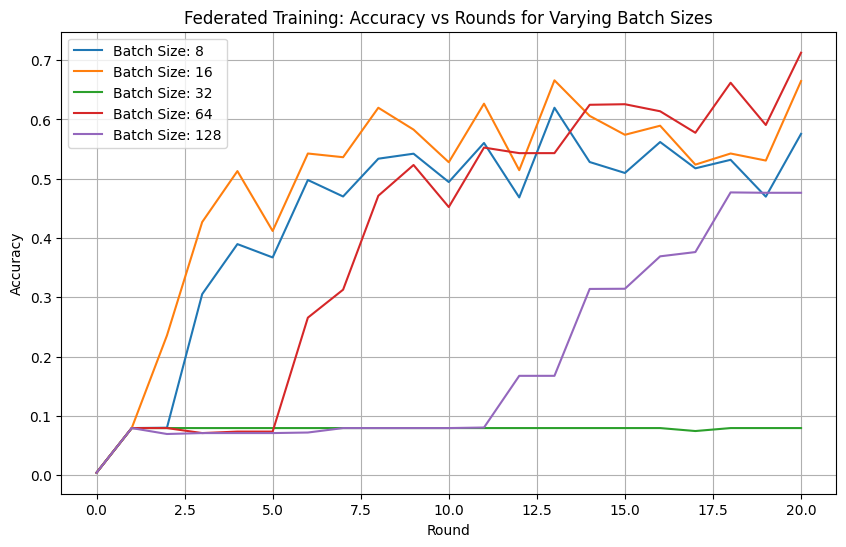

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for batch_size, params, hist in total_results:
    
    accuracies = get_centralized_acc_from_hist(hist)

    plt.plot(accuracies, label=f"Batch Size: {batch_size}")

plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Federated Training: Accuracy vs Rounds for Varying Batch Sizes")
plt.legend()
plt.grid()
plt.show()

When running FL experiments with multiple batch sizes, we do observe that there must be something as "critical" batch size.

However, we must investigate how to identify it.

In [36]:
cohort_sizes = [5, 10, 20, 50, 75, 100]
total_cohort_results = []

for cohort_size in cohort_sizes:

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_cohort_results.append((cohort_size, parameters_for_each_round, hist))

INFO flwr 2025-02-22 13:54:16,455 | 2786322904.py:47 | FL will execute for 20 rounds
INFO flwr 2025-02-22 13:54:16,460 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO flwr 2025-02-22 13:54:16,461 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-22 13:54:16,462 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-22 13:54:16,466 | server_returns_parameters.py:84 | Evaluating initial parameters
 11%|█         | 100/891 [00:00<00:04, 187.39it/s]
INFO flwr 2025-02-22 13:54:17,171 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.33021450042725, {'accuracy': 0.0040625}
INFO flwr 2025-02-22 13:54:17,171 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-22 13:54:17,172 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 100)
INFO flwr 2025-02-22 13:54:17,172 | 4203729913.py:

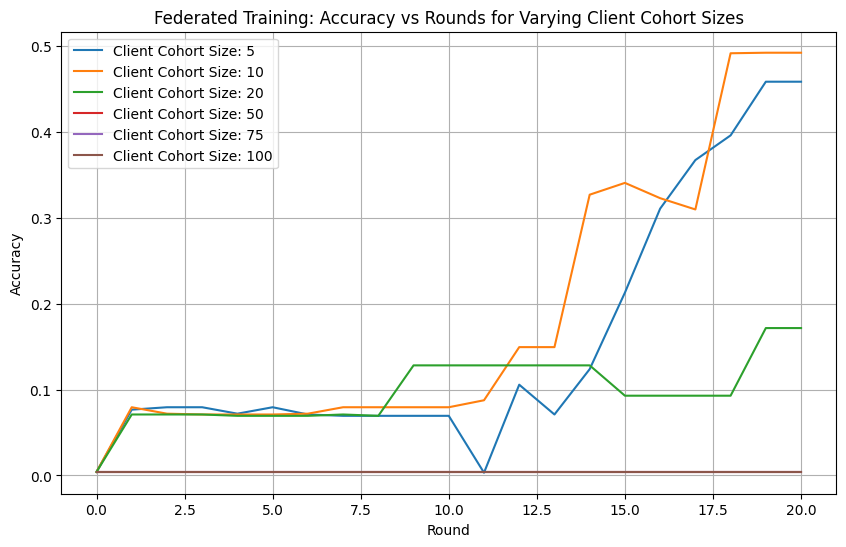

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for cohort_size, params, hist in total_cohort_results:
    
    accuracies = get_centralized_acc_from_hist(hist)

    plt.plot(accuracies, label=f"Client Cohort Size: {cohort_size}")

plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Federated Training: Accuracy vs Rounds for Varying Client Cohort Sizes")
plt.legend()
plt.grid()
plt.show()

When running experiment with varying client cohort sizes, we also observe that such thing as "ideal" client cohort number exists.

However, we have to investigate how to compute it.